In [7]:
import pandas as pd
import os
import spacy
from spacy.matcher import Matcher
import PyPDF2
import csv
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from ftfy import fix_text
from sklearn.neighbors import NearestNeighbors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from warnings import filterwarnings
filterwarnings('ignore')

# LOAD DATA

In [8]:
file_path = os.path.join('..', 'Data', 'jd_structured_data.csv')
jd_df = pd.read_csv(file_path)
jd_df.tail()

,Job Title,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Competitors,Average Salary,Average Revenue,Processed_JD
951,Senior Data Engineer,4.4,Eventbrite,"Nashville, TN","San Francisco, CA",3000.5,2006,Company - Public,Internet,Information Technology,"See Tickets, TicketWeb, Vendini",102.5000,300.000000,THE CHALLENGE Eventbrite world-class data repo...
952,"Project Scientist - Auton Lab, Robotics Institute",2.6,Software Engineering Institute,"Pittsburgh, PA","Pittsburgh, PA",750.5,1984,College / University,Colleges & Universities,Education,-1,73.5000,24319.000761,The Auton Lab Carnegie Mellon University large...
953,Data Science Manager,3.2,"Numeric, LLC","Allentown, PA","Chadds Ford, PA",25.5,-1,Company - Private,Staffing & Outsourcing,Business Services,-1,127.5000,7.500000,Data Science ManagerResponsibilities: Oversee ...
954,Data Engineer,4.8,IGNW,"Austin, TX","Portland, OR",350.5,2015,Company - Private,IT Services,Information Technology,Slalom,103.1539,37.500000,Loading... Title: Data Engineer Location: Aust...
955,Research Scientist – Security and Privacy,3.6,Riverside Research Institute,"Beavercreek, OH","Arlington, VA",750.5,1967,Nonprofit Organization,Federal Agencies,Government,-1,93.5000,75.000000,Returning Candidate? Log back Career Portal cl...


In [9]:
# Uses PDF reader to get all the text from CV
def extract_text_from_pdf(file_path:str):
    with open(file_path, 'rb') as f:
        pdf_reader = PyPDF2.PdfReader(f)
        text = ''
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text


file_path = os.path.join('..', 'Data', 'skills.csv')
skills_data = pd.read_csv(file_path)
skills_data = [row for row in skills_data]


file_path = os.path.join('..', 'Data/CVs', 'CV_Ayse.pdf')

pdf_as_text = extract_text_from_pdf(file_path)

# Create a regular expression pattern to match skills
pattern = re.compile(r'\b(' + '|'.join(re.escape(skill) for skill in skills_data) + r')\b', re.IGNORECASE)

# Find skills in the text using the regular expression pattern
skills = set(match.group(0) for match in pattern.finditer(pdf_as_text))
skills.discard("c")

print(skills)

{'PySpark', 'Programming', 'statistics', 'Big Data', 'Social Media', 'Video', 'Java', 'pandas', 'Machine Learning', 'social media', 'reports', 'Spanish', 'MATLAB', 'Computer Science', 'German', 'Benchmarking', 'statsmodels', 'Data Analysis', 'Mining', 'Python', 'numpy', 'matplotlib', 'English', 'Teaching', 'AI', 'French'}


-------------------------------

# CONTENT BASED APPROACH 1

In [10]:

def ngrams(string, n=3):
    string = fix_text(string) # fix text
    string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
    string = string.lower()
    chars_to_remove = [")","(",".","|","[","]","{","}","'"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    string = re.sub(rx, '', string)
    string = string.replace('&', 'and')
    string = string.replace(',', ' ')
    string = string.replace('-', ' ')
    string = string.title() # normalise case - capital at start of each word
    string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single
    string = ' '+ string +' ' # pad names for ngrams...
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams, lowercase=False)
tfidf = vectorizer.fit_transform(skills)

In [11]:
nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(tfidf)
jd_test = (jd_df['Processed_JD'].values.astype('U'))

def getNearestN(query):
  queryTFIDF_ = vectorizer.transform(query)
  distances, indices = nbrs.kneighbors(queryTFIDF_)
  return distances, indices

distances, indices = getNearestN(jd_test)
test = list(jd_test) 
matches = []

for i,j in enumerate(indices):
    dist=round(distances[i][0],2)
  
    temp = [dist]
    matches.append(temp)
    
matches = pd.DataFrame(matches, columns=['Match confidence'])

# Following recommends Top 5 Jobs based on candidate resume:
jd_df['match']=matches['Match confidence']
top_recommendations = jd_df.sort_values('match', ascending=False).head(5)
top_recommendations

,Job Title,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Competitors,Average Salary,Average Revenue,Processed_JD,match
546,Data Scientist,3.6,Citi,"Jersey City, NJ","New York, NY",10000.000000,1812,Company - Public,Investment Banking & Asset Management,Finance,-1,116.5000,10.000000,"About Citi Citi, leading global bank, approxim...",1.21
565,Market Data Analyst,3.4,SV Microwave,"West Palm Beach, FL","West Palm Beach, FL",350.500000,1991,Company - Public,Telecommunications Manufacturing,Telecommunications,-1,44.0000,75.000000,"seeking creative, data driven Marketing Analys...",1.19
729,Clinical Document Review Scientist,3.5,PACT Pharma,"South San Francisco, CA","South San Francisco, CA",125.500000,2016,Company - Private,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,-1,103.1539,24319.000761,"PACT Pharma exciting, well-funded clinical sta...",1.19
337,MED TECH/LAB SCIENTIST - LABORATORY,3.6,Beebe Healthcare,"Lewes, DE","Lewes, DE",3000.500000,1935,Nonprofit Organization,Health Care Services & Hospitals,Health Care,-1,103.1539,300.000000,Evening: 3P-1130P Night Shift 11P-730A Include...,1.19
214,Data Scientist,-1.0,Seen by Indeed,"Pittsburgh, PA","Austin, TX",3027.393199,-1,Company - Private,-1,-1,-1,103.1539,24319.000761,With one application considered thousands tech...,1.19


## Explanations Approach 1

#### Highlight the matched skills in the job descriptions 

In [12]:
from IPython.display import HTML
# 8. Job Description Highlights
def highlight_matched_skills(job_description, matched_skills_job):
    # Highlight matched skills in the job description
    for skill in matched_skills_job:
        job_description = job_description.replace(skill, f'<span style="background-color: #FFFF00">{skill}</span>')
    return job_description

for i, job_row in top_recommendations.iterrows():
    job_title = job_row['Job Title']
    
    # Get the matched skills for this job
    matched_skills_job = set([skill.lower() for skill in skills if skill.lower() in job_row['Processed_JD']])
    
    # Display debugging information
    print(f"\nExplanation for {job_title}:")
    
    # Example usage
    job_description = job_row['Processed_JD']
    pattern = re.compile(r'\b(' + '|'.join(re.escape(skill) for skill in skills) + r')\b', re.IGNORECASE)
    matched_skills_job = set(match.group(0) for match in pattern.finditer(job_description))
    def replace_with_format(match):
        skill = match.group(0)
        return f'<span style="background-color: #FFFF00">{skill}</span>'
    
    # Replace matches with specified format
    modified_text = pattern.sub(replace_with_format, job_description)
    

    # Display the highlighted job description
    display(HTML(modified_text))


Explanation for Data Scientist:



Explanation for Market Data Analyst:



Explanation for Clinical Document Review Scientist:



Explanation for MED TECH/LAB SCIENTIST - LABORATORY:



Explanation for Data Scientist:


#### Print out as text the matched skills

In [13]:
# Get the tokenized and lowercased skills for debugging
tokenized_skills = [skill.lower() for skill in skills]
print("Skills found in the CV:", tokenized_skills)
    
for i, job_row in top_recommendations.iterrows():
    job_title = job_row['Job Title']
    
    # Get the matched skills for this job
    matched_skills_job = set([skill.lower() for skill in skills if skill.lower() in job_row['Processed_JD']])
    
    # Display debugging information
    print(f"\nExplanation for {job_title}:")
    print(f"Matched skills:' {matched_skills_job}")

Skills found in the CV: ['pyspark', 'programming', 'statistics', 'big data', 'social media', 'video', 'java', 'pandas', 'machine learning', 'social media', 'reports', 'spanish', 'matlab', 'computer science', 'german', 'benchmarking', 'statsmodels', 'data analysis', 'mining', 'python', 'numpy', 'matplotlib', 'english', 'teaching', 'ai', 'french']

Explanation for Data Scientist:
Matched skills:' {'mining', 'ai'}

Explanation for Market Data Analyst:
Matched skills:' {'mining', 'ai'}

Explanation for Clinical Document Review Scientist:
Matched skills:' {'data analysis', 'ai'}

Explanation for MED TECH/LAB SCIENTIST - LABORATORY:
Matched skills:' {'reports', 'ai'}

Explanation for Data Scientist:
Matched skills:' set()


#### Word Cloud the matched skills


Explanation for Data Scientist:


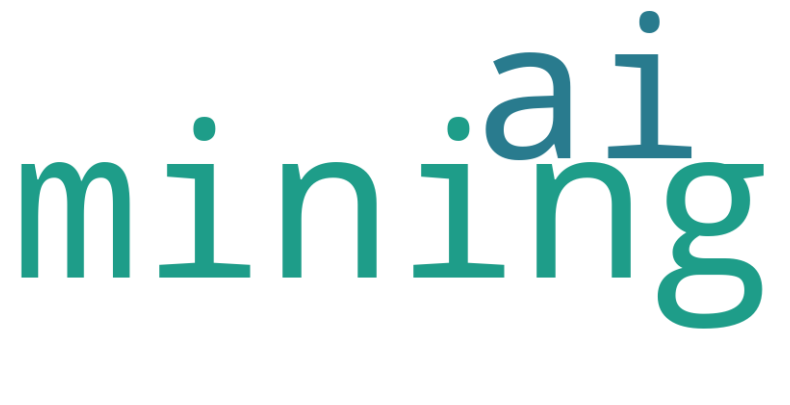


Explanation for Market Data Analyst:


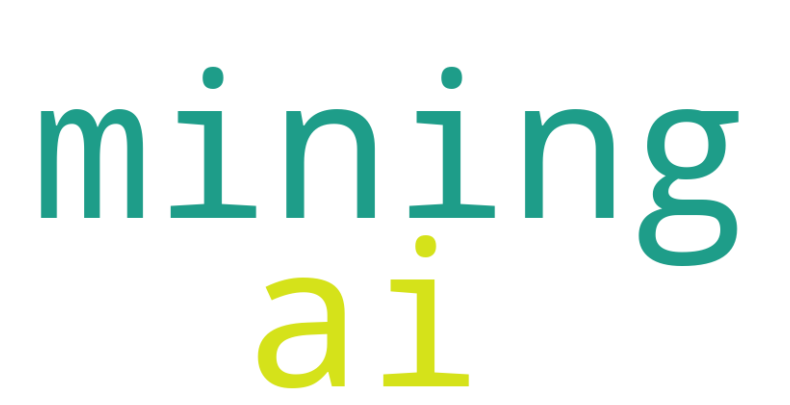


Explanation for Clinical Document Review Scientist:


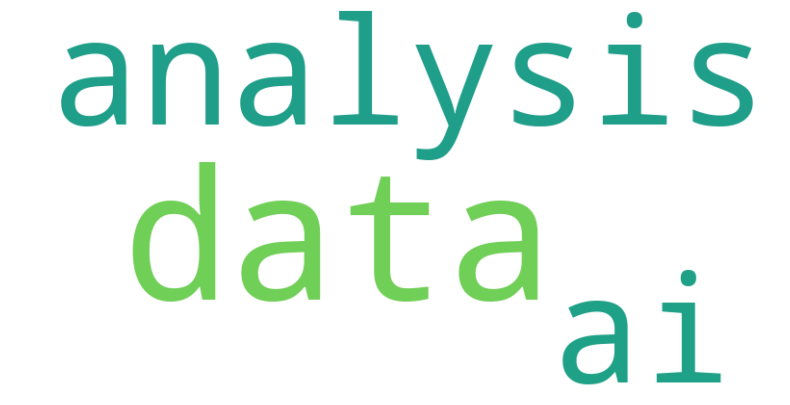


Explanation for MED TECH/LAB SCIENTIST - LABORATORY:


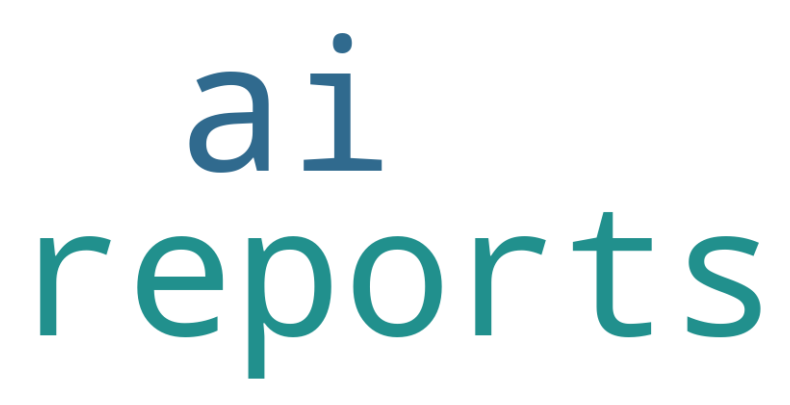


Explanation for Data Scientist:


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [14]:
# 4. Visualizations (Word Cloud)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, job_row in top_recommendations.iterrows():
    job_title = job_row['Job Title']
    
    # Get the matched skills for this job
    matched_skills_job = set([skill.lower() for skill in skills if skill.lower() in job_row['Processed_JD']])
    
    # Display debugging information
    print(f"\nExplanation for {job_title}:")

    # Generate a word cloud for matched skills
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(matched_skills_job))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

--------------------------------------------

# CONTENT BASED APPROACH 2

In [15]:
# content-based recommendation system using TF-IDF and cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def preprocess_text(text):
    # Implement your text preprocessing steps here
    # For example, lowercasing and removing punctuation
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

# Assuming cv_text is the text of the CV as a string
cv_text = pdf_as_text

# Assuming df_jobs is your job dataframe
# Preprocess the job descriptions
jd_df['Processed_JD'] = jd_df['Processed_JD'].apply(preprocess_text)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([cv_text] + jd_df['Processed_JD'].tolist())

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1:]).flatten()

# Add similarity scores to the dataframe
jd_df['Similarity'] = cosine_similarities

# Recommend top N jobs based on similarity scores
top_jobs = jd_df.nlargest(5, 'Similarity')
display(top_jobs)

# Access the TF-IDF matrix
tfidf_matrix_array = tfidf_matrix.toarray()

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a dataframe with feature names and their average TF-IDF weights across all job descriptions
tfidf_df = pd.DataFrame({'Term': feature_names, 'Average_TFIDF_Weight': tfidf_matrix_array[1:].mean(axis=0)})



,Job Title,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Competitors,Average Salary,Average Revenue,Processed_JD,match,Similarity
116,"Data Scientist, Rice University",4.3,Trilogy Ed,"Houston, TX","New York, NY",3000.5,2015,Subsidiary or Business Segment,Education Training Services,Education,"General Assembly, Kaplan University, Ironhack",87.5,24319.000761,trilogy education partners universities offer ...,1.05,0.097191
526,Geospatial Software Developer and Data Scientist,3.7,Applied Research Laboratories,"Austin, TX","Austin, TX",750.5,-1,College / University,Colleges & Universities,Education,-1,105.5,24319.000761,job posting title geospatial software develope...,1.13,0.092092
789,Geospatial Software Developer and Data Scientist,3.7,Applied Research Laboratories,"Austin, TX","Austin, TX",750.5,-1,College / University,Colleges & Universities,Education,-1,105.5,24319.000761,job posting title geospatial software develope...,1.13,0.092092
200,Senior Data Scientist,4.0,Autodesk,"San Francisco, CA","San Rafael, CA",7500.5,1982,Company - Public,Computer Hardware & Software,Information Technology,-1,150.5,3500.000000,location san francisco ca united states job id...,1.09,0.090676
311,Senior Data Scientist,4.0,Autodesk,"San Francisco, CA","San Rafael, CA",7500.5,1982,Company - Public,Computer Hardware & Software,Information Technology,-1,150.5,3500.000000,location san francisco ca united states job id...,1.09,0.090676


## Explanations Approach 2

In [16]:
# These are skills that are not only important within a specific job description 
# but are also relatively rare across the entire dataset.
# When these top skills align with the skills mentioned in the candidate's CV, 
# the system is likely to recommend jobs that value and require those specific skills

# Extract top skills based on TF-IDF weights
top_skills = tfidf_df.sort_values(by='Average_TFIDF_Weight', ascending=False).head(5)['Term'].tolist()
print(f"Top Skills: {', '.join(top_skills)}")


# Looking at value counts, or frequencies, is crucial in TF-IDF-based recommendation systems because 
# TF-IDF prioritizes terms that are both common within a specific job description and rare across the entire dataset
# The emphasis is on terms that are both relevant to a specific job description and distinctive in the broader dataset. 
# This approach aims to provide personalized recommendations by focusing on the unique characteristics mentioned in the CV and job descriptions.

# Most Common
top_industries = jd_df['Industry'].value_counts().head(3).index.tolist()
top_sectors = jd_df['Sector'].value_counts().head(3).index.tolist()
top_job_titles = jd_df['Job Title'].value_counts().head(3).index.tolist()
top_company_types = jd_df['Type of ownership'].value_counts().head(3).index.tolist()
print(f"Most Common Company Types: {', '.join(top_company_types)}")
print(f"Most Common Job Titles: {', '.join(top_job_titles)}")
print(f"Most Common Industries: {', '.join(top_industries)}")
print(f"Most Common Sectors: {', '.join(top_sectors)}")


Top Skills: data, experience, business, work, team
Most Common Company Types: Company - Private, Company - Public, Nonprofit Organization
Most Common Job Titles: Data Scientist, Data Engineer, Senior Data Scientist
Most Common Industries: Biotech & Pharmaceuticals, IT Services, Computer Hardware & Software
Most Common Sectors: Information Technology, Biotech & Pharmaceuticals, Business Services


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for Most Common Industries
plt.figure(figsize=(10, 6))
sns.countplot(y='Industry', data=jd_df, order=jd_df['Industry'].value_counts().index[:3])
plt.title('Most Common Industries')
plt.xlabel('Count')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

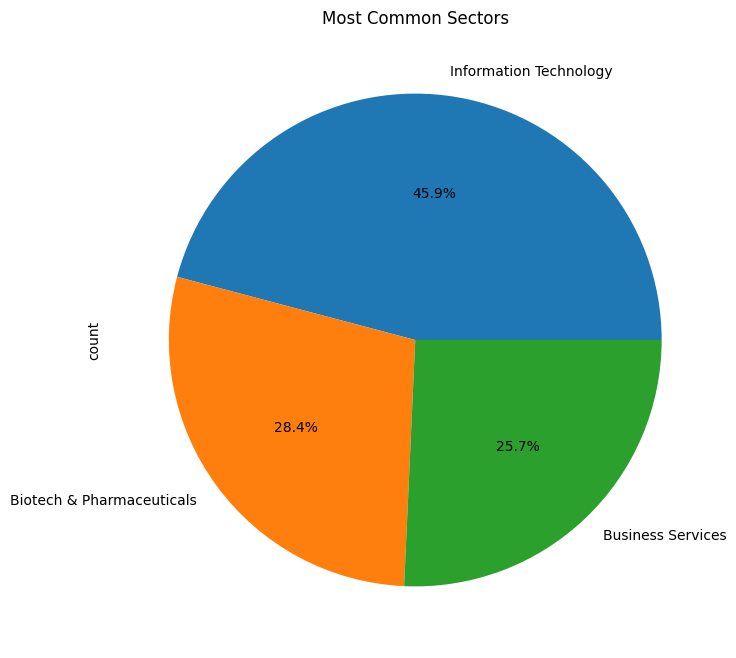

In [18]:
# Pie chart for Most Common Sectors
plt.figure(figsize=(8, 8))
jd_df['Sector'].value_counts().head(3).plot.pie(autopct='%1.1f%%')
plt.title('Most Common Sectors')
plt.show()

-----------------------------

# CONTENT BASED WITH KNOWLEDGE BASED APPROACH

In [19]:
# Example rule-based knowledge
preferred_industry = "Advertising & Marketing"
preferred_location = "New York, NY"

# Apply knowledge-based rules
knowledge_based_jobs = jd_df[
    (jd_df['Industry'] == preferred_industry) & 
(jd_df['Location'] == preferred_location)
]

# knowledge_based_jobs = jd_df[
#     (jd_df['Location'] == preferred_location)
# ]

# Combine with content-based similarity scores
knowledge_based_jobs['FinalScore'] = knowledge_based_jobs['Similarity'] + 0.2

# Recommend top N jobs based on the combined score
top_jobs_combined = knowledge_based_jobs.nlargest(5, 'FinalScore')
top_jobs_combined

,Job Title,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Competitors,Average Salary,Average Revenue,Processed_JD,match,Similarity,FinalScore
651,Data Scientist,3.5,Crossix Solutions,"New York, NY","New York, NY",350.5,2005,Company - Public,Advertising & Marketing,Business Services,-1,104.5,24319.000761,crossix seeking intellectually curious resourc...,1.12,0.050822,0.250822
878,Data Scientist,3.5,Crossix Solutions,"New York, NY","New York, NY",350.5,2005,Company - Public,Advertising & Marketing,Business Services,-1,104.5,24319.000761,crossix seeking intellectually curious resourc...,1.12,0.050822,0.250822
4,Data Scientist,2.9,Affinity Solutions,"New York, NY","New York, NY",125.5,1998,Company - Private,Advertising & Marketing,Business Services,"Commerce Signals, Cardlytics, Yodlee",114.5,24319.000761,data scientist affinity solutions marketing cl...,1.13,0.043665,0.243665


### Explanations

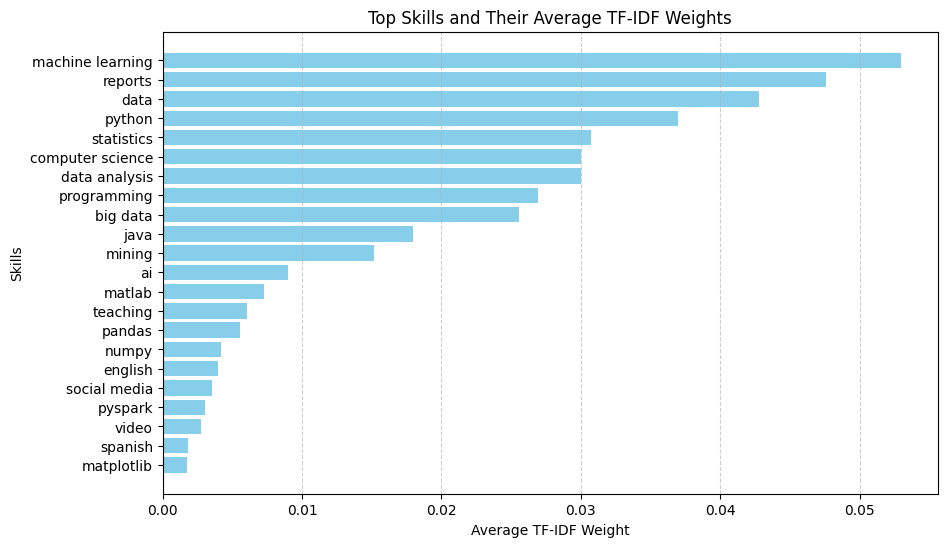

Top Terms Contributing to Similarity:
                   Term  Average_TFIDF_Weight
4686           learning              0.052955
5983   machine learning              0.052955
5982            machine              0.052955
9094            reports              0.047592
1406               data              0.042795
8057             python              0.036940
10545        statistics              0.030726
9833            science              0.029999
1227   computer science              0.029999
1226           computer              0.029999
231            analysis              0.029998
1414      data analysis              0.029998
7582        programming              0.026915
825                 big              0.025592
826            big data              0.025592
3784               java              0.017983
6199             mining              0.015145
107                  ai              0.009026
5992             matlab              0.007289
11150          teaching              0.006

In [113]:
import random
import string
import matplotlib.pyplot as plt



# Set the length of the random string
string_length = 5


job_desc_skills = []
pattern2 = re.compile(r'\b(' + '|'.join(re.escape(skill) for skill in skills_data) + r')\b', re.IGNORECASE)
for jd in jd_df["Processed_JD"]:
    skills_special_token = []
    # Find skills in the text using the regular expression pattern
    skills_list = list(match.group(0) for match in pattern.finditer(jd))
    for skill in skills_list:
        random_string = ''.join(random.choice(string.ascii_letters) for _ in range(string_length))
        skills_special_token.append(skill)
        skills_special_token.append(random_string)
    job_desc_skills.append(" ".join(skills_special_token))    
        
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(job_desc_skills)
# Access the TF-IDF matrix
tfidf_matrix_array = tfidf_matrix.toarray()
# Get feature names from the vectorizer
new_features = []
new_scores =[]
feature_names = vectorizer.get_feature_names_out()
# Create a dataframe with feature names and their average TF-IDF weights across all job descriptions
tfidf_df = pd.DataFrame({'Term': feature_names, 'Average_TFIDF_Weight': tfidf_matrix_array[1:].mean(axis=0)})
# Sort the dataframe by TF-IDF weights to identify important terms
top_terms = tfidf_df.sort_values(by='Average_TFIDF_Weight', ascending=False).head(30)
df2 = top_terms.groupby('Average_TFIDF_Weight')
for i in range(len(list(df2.groups.keys()))):
    group = df2.get_group(list(df2.groups.keys())[i])
    terms = list(group["Term"])    
    longest_word = max(terms, key=len, default=None)
    superword = [word for word in terms if longest_word in word]
    new_features.extend(superword)
    for i in range(len(superword)):
        new_scores.append(list(group["Average_TFIDF_Weight"])[0] )
final_df = pd.DataFrame({
    'Term': new_features,
    'Average_TFIDF_Weight': new_scores
})        







# Extract the top terms and their weights
top_terms_skills = final_df['Term']
top_terms_weights = final_df['Average_TFIDF_Weight']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_terms_skills, top_terms_weights, color='skyblue')
plt.xlabel('Average TF-IDF Weight')
plt.ylabel('Skills')
plt.title('Top Skills and Their Average TF-IDF Weights')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print(f"Top Terms Contributing to Similarity:")
print(top_terms[['Term', 'Average_TFIDF_Weight']])
print("\nKnowledge-Based Criteria:")
print(f"Preferred Industry: {preferred_industry}")
print(f"Preferred Location: {preferred_location}")


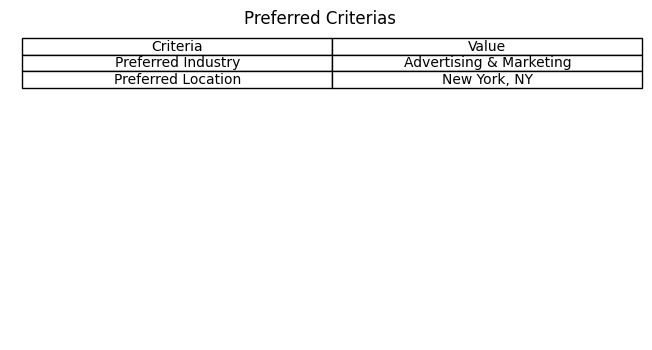

In [112]:
# Table for knowledge-based criteria
criteria_data = {
    'Criteria': ['Preferred Industry', 'Preferred Location'],
    'Value': [preferred_industry, preferred_location]
}

criteria_df = pd.DataFrame(criteria_data)
plt.figure(figsize=(8, 4))
plt.table(cellText=criteria_df.values,
          colLabels=criteria_df.columns,
          cellLoc='center', loc='upper left')
plt.axis('off')
plt.title('Preferred Criterias')
plt.show()

--------------------------

**Why not Collaborative filtering?**  
Collaborative filtering is a technique that makes automatic predictions (filtering) about the preference of a user by collecting preferences from many users (collaborating). Here, the collaborative filtering approach might not be the most suitable. Collaborative filtering is generally effective when you have interactions between multiple users and items. Collaborative filtering could work in this case, but with a small number of users (3 CVs) and a larger number of items (900+ jobs), traditional collaborative filtering may face challenges such as sparsity and the cold start problem. The cold start problem arises when there is limited or no interaction data for some users or items.

------------------------------------

In [ ]:
# #Ali's Code 
# #In this code, I commented the part where we extract skills from the job description and train the model only on them becuase I assume we could lose information


# # Convert all skills into one string
# s = " ".join(skills)

# # Store Job descriptions in a dataframe
# jd_test = (jd_df['Processed_JD'].values.astype('U'))


# # Find skills in the job descriptions using the regular expression pattern
# #queries = [] 
# #for jd in jd_test: 
#  #   skills_ds = " ".join(set(match.group(0) for match in pattern.finditer(jd)))
#   #  queries.append(skills_ds)


# # Convert job descriptions into Doc2Vec training instances
# tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
#                              tags=[str(i)]) for i,
#                doc in enumerate(jd_test)]
 
# # Train the Doc2vec model
# model = Doc2Vec(vector_size=10,
#                 min_count=2, epochs=100)
# model.build_vocab(tagged_data)
# model.train(tagged_data,
#             total_examples=model.corpus_count,
#             epochs=model.epochs)




# # Convert skills from CV to a vector
# inferred_vector_dm = model.infer_vector(word_tokenize(s.lower()))  
# #Find most similar job descriptions to our CV
# sim = model.docvecs.most_similar([inferred_vector_dm],topn=len(jd_test))
# sorted_list = sorted(sim, key=lambda x: x[0]) 
# dist = [t[1] for t in sorted_list]
# sim = np.reshape(dist,[-1,1])    
# matches = pd.DataFrame(sim, columns=['Match confidence'])

# # Following recommends Top 5 Jobs based on candidate resume:
# jd_df['match']=matches['Match confidence']
# jd_df.sort_values('match').tail(5)


In [301]:
dfs = []
for row in df["skills"]:
    new_df  = pd.DataFrame(row)
    new_df.set_index('name', inplace=True)

    # Extract the 'required_proficiency' column and transpose the DataFrame
    result_df = new_df['required_proficiency'].transpose()

    # Now 'result_df' is a DataFrame with each skill as a column and required proficiency as a row
    dfs.append(result_df)
merged_df = pd.concat(dfs,axis=1).transpose()

# Now 'merged_df' contains all the rows from the original DataFrames
merged_df

name,maxwell-murray,miller,durham,castillo,vazquez,kelly,davidson-garcia,oliver,anderson,rowe,...,wallace,larson,pace,miller-duncan,green-smith,mitchell,johnston,sanford,ochoa,caldwell
required_proficiency,1.0,3.0,2.0,4.0,3.0,0.0,0.0,4.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,0.0,5.0,2.0,2.0,0.0,0.0,1.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,5.0,5.0,5.0,4.0,0.0,0.0,1.0,3.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,1.0,3.0,3.0,2.0,0.0,2.0,0.0,4.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,1.0,4.0,5.0,1.0,2.0,1.0,0.0,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,2.0,5.0,4.0,4.0,1.0,2.0,2.0,5.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,5.0,5.0,5.0,4.0,0.0,1.0,1.0,5.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,2.0,4.0,4.0,2.0,1.0,2.0,0.0,5.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,0.0,5.0,3.0,2.0,1.0,3.0,2.0,1.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_proficiency,0.0,4.0,4.0,2.0,3.0,0.0,0.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [289]:
def dict_to_df(df):
    for col in df.columns:
        if str(type(df[col][0])) == "<class 'dict'>":
            new_df = pd.DataFrame(pd.Series(df["company"]).tolist())
            new_df = dict_to_df(new_df)
            df = df.drop(columns=[col])
            df = pd.concat([df, new_df],axis=1)

    return df

In [470]:
import json

file_path = os.path.join('..', 'Data', 'vacancies_data.json')
with open(file_path, 'r') as file:
    json_data = json.load(file)


df = pd.DataFrame(json_data)


vac_df = dict_to_df(df)[["id","title","name"]]

dfs = []
for row in df["skills"]:
    new_df  = pd.DataFrame(row)
    new_df.set_index('name', inplace=True)

    # Extract the 'required_proficiency' column and transpose the DataFrame
    result_df = new_df['required_proficiency'].transpose()

    # Now 'result_df' is a DataFrame with each skill as a column and required proficiency as a row
    dfs.append(result_df)
merged_df = pd.concat(dfs,axis=1).transpose()

# Now 'merged_df' contains all the rows from the original DataFrames
merged_df= merged_df.fillna(-1)
vaccancies = pd.concat([vac_df,merged_df.reset_index()],axis=1).drop(columns=["index"])
vaccancies 



,id,title,name,maxwell-murray,miller,durham,castillo,vazquez,kelly,davidson-garcia,...,wallace,larson,pace,miller-duncan,green-smith,mitchell,johnston,sanford,ochoa,caldwell
0,12,Chartered management accountant,Thompson PLC,1.0,3.0,2.0,4.0,3.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,20,English as a foreign language teacher,"Harris, Marshall and Smith",0.0,5.0,2.0,2.0,0.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,31,Chief Marketing Officer,Washington-Gordon,5.0,5.0,5.0,4.0,0.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,8,Financial planner,"Gibson, Trujillo and Lowe",1.0,3.0,3.0,2.0,0.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,30,Public relations account executive,Holland-Harris,1.0,4.0,5.0,1.0,2.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,12,Jewellery designer,Thompson PLC,2.0,5.0,4.0,4.0,1.0,2.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,10,Press photographer,"Phillips, Warren and Caldwell",5.0,5.0,5.0,4.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,19,Dispensing optician,Mack Ltd,2.0,4.0,4.0,2.0,1.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,18,Product manager,Petersen and Sons,0.0,5.0,3.0,2.0,1.0,3.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,15,Exhibition designer,Guerrero-Wagner,0.0,4.0,4.0,2.0,3.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [471]:
file_path = os.path.join('..', 'Data', 'applicants_data.json')
with open(file_path, 'r') as file:
    json_data = json.load(file)

df = pd.DataFrame(json_data)

dfs = []
for row in df["skills"]:
    new_df  = pd.DataFrame(row)
    new_df.set_index('name', inplace=True)

    # Extract the 'required_proficiency' column and transpose the DataFrame
    result_df = new_df['proficiency'].transpose()

    # Now 'result_df' is a DataFrame with each skill as a column and required proficiency as a row
    dfs.append(result_df)
merged_df = pd.concat(dfs,axis=1)
merged_df.columns = df["name"].tolist()
applicants_df = merged_df.transpose()

# Now 'merged_df' contains all the rows from the original DataFrames
applicants_df = applicants_df.fillna(-1)
applicants_df

name,maxwell-murray,miller,durham,castillo,vazquez,kelly,davidson-garcia,oliver,anderson,rowe,...,wallace,larson,pace,miller-duncan,green-smith,mitchell,johnston,sanford,ochoa,caldwell
David Chapman,0.0,2.0,2.0,4.0,0.0,0.0,0.0,3.0,4.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Dennis Reed,3.0,4.0,5.0,4.0,0.0,1.0,2.0,4.0,1.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Robert Scott,0.0,4.0,3.0,1.0,0.0,0.0,0.0,4.0,3.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Michael Martin,0.0,5.0,3.0,3.0,1.0,0.0,0.0,5.0,2.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Brian Ferguson,4.0,5.0,4.0,2.0,1.0,2.0,0.0,5.0,3.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Keith Banks,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5.0,3.0,3.0,3.0,1.0,2.0,1.0,4.0,4.0,5.0
Clinton Harris,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3.0,2.0,2.0,3.0,1.0,2.0,1.0,3.0,5.0,5.0
Victoria Sims,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,4.0,2.0,2.0,3.0,1.0,1.0,1.0,4.0,5.0,5.0
Rachel Briggs,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3.0,2.0,2.0,4.0,1.0,1.0,1.0,2.0,5.0,5.0


In [463]:
[1,2,3] + [3,2,1]

[1, 2, 3, 3, 2, 1]

In [500]:
#df["applications"]["applicant"]["application"]["hired_at"]

df["applications"][0][1]["hired_at"] == None


True

In [501]:
# for every applicant
list_of_minus_ones = [-1] * 40
final_df = pd.DataFrame()
for i  in range(len(applicants_df)):
    applications = df["applications"][i]
    name = df["name"][i]
    indices = []
    columns = []
    
    for j in range(len(applications)):
        company_id = df["applications"][i][j]["vacancy"]["company"]["id"]
        if df["applications"][i][j]["hired_at"] == None:
            hired = 0
        else: 
            hired = 1    

        index  = vaccancies.loc[vaccancies['id'] == company_id].index[0]
        indices.append(index)
        
        columns.append(vaccancies.iloc[index])
    k=0
    skills = []    
    for j in range(len(vaccancies)):
        if j in indices:
            app = applicants_df.iloc[i] 
            skills.append(list(columns[k]) + list(app)+ [name,hired])
            k+=1

    df_test = pd.DataFrame(skills)
    
    
    if len(df_test.columns)>0:
        vaccancies_cols = vaccancies.columns
        applicants_cols = list("Applicant " + applicants_df.columns) + ["applicant name","hired"]
        cols = list(vaccancies_cols)+ applicants_cols
        df_test.columns =  cols
        final_df = pd.concat([final_df,df_test])
final_df

,id,title,name,maxwell-murray,miller,durham,castillo,vazquez,kelly,davidson-garcia,...,Applicant pace,Applicant miller-duncan,Applicant green-smith,Applicant mitchell,Applicant johnston,Applicant sanford,Applicant ochoa,Applicant caldwell,applicant name,hired
0,30,Public relations account executive,Holland-Harris,1.0,4.0,5.0,1.0,2.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,David Chapman,0
1,18,Product manager,Petersen and Sons,0.0,5.0,3.0,2.0,1.0,3.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,David Chapman,0
0,20,English as a foreign language teacher,"Harris, Marshall and Smith",0.0,5.0,2.0,2.0,0.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Dennis Reed,0
1,8,Financial planner,"Gibson, Trujillo and Lowe",1.0,3.0,3.0,2.0,0.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Dennis Reed,0
0,12,Chartered management accountant,Thompson PLC,1.0,3.0,2.0,4.0,3.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Robert Scott,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,58,"Geologist, engineering",Farmer-Jones,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,3.0,1.0,2.0,1.0,4.0,5.0,5.0,Mr. John Patton,1
1,38,Engineering geologist,Flores-Rogers,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,3.0,1.0,2.0,1.0,4.0,5.0,5.0,Mr. John Patton,1
2,59,Product designer,"Parks, Reynolds and Casey",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,3.0,1.0,2.0,1.0,4.0,5.0,5.0,Mr. John Patton,1
0,38,Engineering geologist,Flores-Rogers,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,2.0,3.0,1.0,1.0,1.0,4.0,5.0,5.0,Victoria Sims,0
